In [1]:
!date

Mon Feb 24 16:12:40 PST 2020


# Processing 10x data

In [2]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [183]:
path = "/home/sina/projects/mop/mop_10xv3"
file_paths = glob.glob(path + "/out*/counts_filtered/adata.h5ad")

In [184]:
file_paths = np.sort(file_paths).tolist()

In [185]:
file_paths

['/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_A01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_B01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_C01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_D01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_E01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_F01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_G12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_181211_01_H12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_190430_01_A08_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/out_L8TX_190430_01_B08_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_

In [186]:
batch_id = [
"3L8TX_181211_01_A01",
"4L8TX_181211_01_B01",
"5L8TX_181211_01_C01",
"6L8TX_181211_01_D01",
"7L8TX_181211_01_E01",
"8L8TX_181211_01_F01",
"1L8TX_181211_01_G12",
"2L8TX_181211_01_H12",
"9L8TX_190430_01_A08",    
"10L8TX_190430_01_B08",
"11L8TX_190430_01_F08",    
"12L8TX_190430_01_G08"]

In [187]:
%%time
files = []
for fidx, f in enumerate(file_paths):
    print("{} of {}".format(fidx+1, len(file_paths)))
    files.append(anndata.read_h5ad(f))

1 of 12
2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12
12 of 12
CPU times: user 1.42 s, sys: 2.53 s, total: 3.95 s
Wall time: 3.94 s


In [188]:
adata = files[0].concatenate(*files[1:], batch_categories=batch_id)

In [189]:
adata

AnnData object with n_obs × n_vars = 169200 × 31053 
    obs: 'batch'
    var: 'gene_name'

In [190]:
adata.obs

,batch
AAACCCAAGGTGTGAC-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCAAGTTGGACG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACACAAACGG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGACACAG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGCGCTTG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
...,...
TTTGTTGTCATTGCGA-12L8TX_190430_01_G08,12L8TX_190430_01_G08
TTTGTTGTCCCAACTC-12L8TX_190430_01_G08,12L8TX_190430_01_G08
TTTGTTGTCCGACAGC-12L8TX_190430_01_G08,12L8TX_190430_01_G08
TTTGTTGTCTATGCCC-12L8TX_190430_01_G08,12L8TX_190430_01_G08


In [191]:
adata.obs.head()

,batch
AAACCCAAGGTGTGAC-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCAAGTTGGACG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACACAAACGG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGACACAG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGCGCTTG-3L8TX_181211_01_A01,3L8TX_181211_01_A01


In [192]:
ca = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.annotation.csv", index_col=0)
cm = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.membership.csv", index_col=0)

In [193]:
adata = adata[adata.obs.index.isin(cm.index)]

In [194]:
adata.obs["cluster_id"] = adata.obs.index.map(cm["x"])

Trying to set attribute `.obs` of view, copying.


In [195]:
adata.obs["cluster_label"]  = adata.obs["cluster_id"].map(ca["cluster_label"])
adata.obs["subclass_label"] = adata.obs["cluster_id"].map(ca["subclass_label"])
adata.obs["class_label"]    = adata.obs["cluster_id"].map(ca["class_label"])

In [196]:
le = LabelEncoder()
adata.obs["cluster_id"] = le.fit_transform(adata.obs.cluster_label.values)

le = LabelEncoder()
adata.obs["subclass_id"] = le.fit_transform(adata.obs.subclass_label.values)

le = LabelEncoder()
adata.obs["class_id"] = le.fit_transform(adata.obs.class_label.values)

In [197]:
adata.obs.cluster_label.nunique()

147

In [198]:
adata.X

<94162x31053 sparse matrix of type '<class 'numpy.float32'>'
	with 554748124 stored elements in Compressed Sparse Row format>

In [199]:
adata

AnnData object with n_obs × n_vars = 94162 × 31053 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name'

# Add data to adata

In [200]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 0.5e6
disp_threshold = 10

mito_criteria = 50

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [201]:
# Writing cell_TPM, gene_TPM, n_genes, and percent_mito for each cell
adata.obs["n_counts"] = adata.X.sum(1)
adata.var["n_counts"] = np.asarray(adata.X.sum(0)).reshape(-1)
adata.var["n_cells"] = np.asarray((adata.X>0).sum(0)).reshape(-1)

mito_genes = adata.var.gene_name.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100
adata.obs["n_genes"] = (adata.X>0).sum(axis=1)

# IGNORE THIS SECTION

In [32]:
adata.layers["X"] = adata.X

In [33]:
mtx = adata.X.todense()

In [34]:
row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1)
norm = mtx/row_sum[:,None]

In [35]:
adata.X = norm*1000000
adata.layers["log1p"] = np.log1p(norm)

In [36]:
scanp.pp.log1p(adata)

## Highly variable genes

In [37]:
adata.X = csr_matrix(adata.X)

# Filter

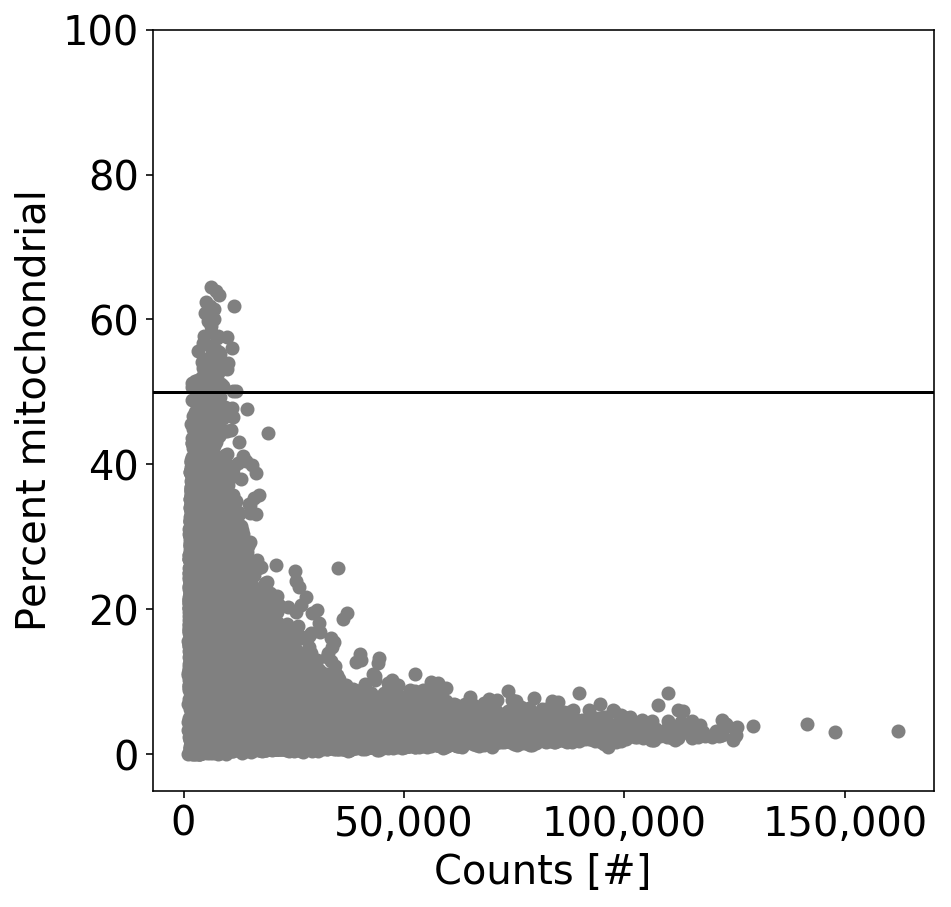

In [202]:
fig, ax = plt.subplots(figsize=(7,7))

x = adata.obs["n_counts"]
y = adata.obs["percent_mito"]

ax.scatter(x, y, color="grey")
ax.axhline(y=mito_criteria, color="k")

ax.set_xlabel("Counts [#]")
ax.set_ylabel("Percent mitochondrial")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(-5, 100)

plt.show()

In [203]:
def plot_yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

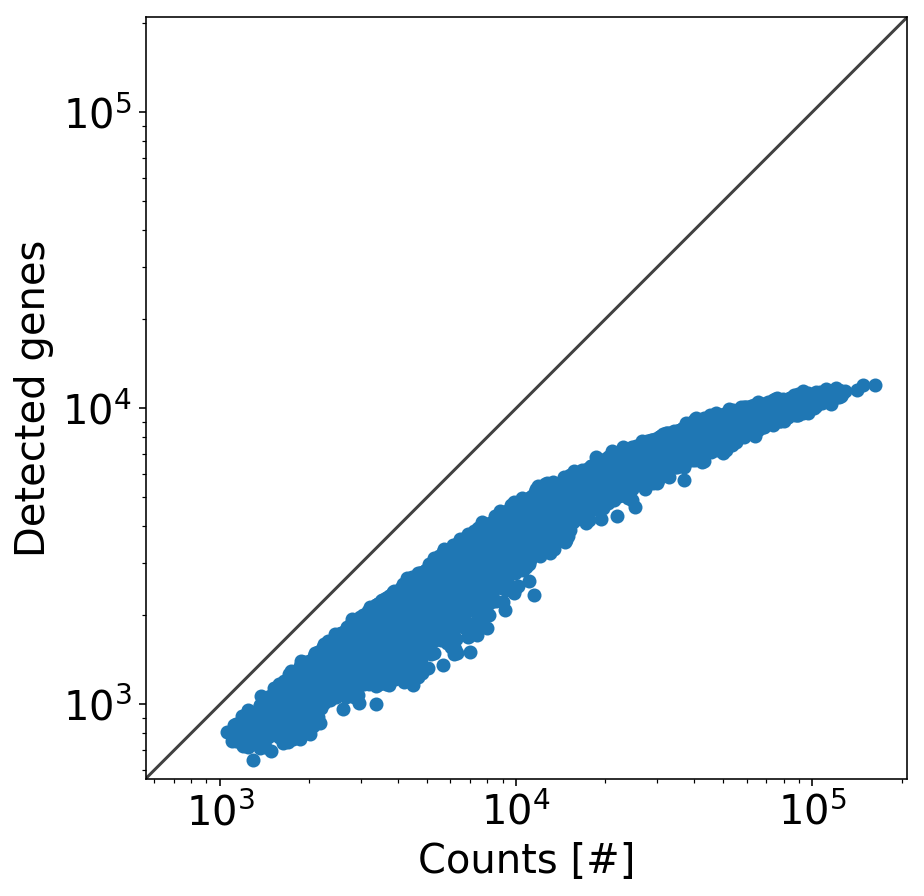

In [204]:
fig, ax = plt.subplots(figsize=(7,7))

x = adata.obs["n_counts"]
y = adata.obs["n_genes"]

ax.scatter(x, y)

ax.set_xlabel("Counts [#]")
ax.set_ylabel("Detected genes")
ax.set_xscale("log")
ax.set_yscale("log")
plot_yex(ax)
plt.show()

In [205]:
adata.shape[0]*0.01

941.62

In [206]:
mask = adata.obs["percent_mito"]<mito_criteria
tmp = adata[mask]

In [207]:
mask = adata.var["n_cells"]>adata.shape[0]*0.01

In [208]:
mask.sum()

18589

In [209]:
gene = tmp[:,mask].copy()

In [210]:
gene

AnnData object with n_obs × n_vars = 94089 × 18589 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'n_counts', 'percent_mito', 'n_genes'
    var: 'gene_name', 'n_counts', 'n_cells'

In [211]:
# For each gene, compute the dispersion and store it
# mtx = gene.X.todense()
# mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
# var = np.asarray(np.power(mtx, 2).mean(axis=0)).reshape(-1) - mean**2
# 
# dispersion = var / mean

## Perform matrix ops

In [212]:
gene.layers["X"] = gene.X

In [213]:
mtx = gene.X.todense()

In [214]:
row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1)
norm = mtx/row_sum[:,None]

In [215]:
gene.X = norm*1000000
gene.layers["log1p"] = np.log1p(norm)

In [216]:
scanp.pp.log1p(gene)

## Highly variable genes

In [217]:
gene.X = csr_matrix(gene.X)

In [218]:
gene

AnnData object with n_obs × n_vars = 94089 × 18589 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'n_counts', 'percent_mito', 'n_genes'
    var: 'gene_name', 'n_counts', 'n_cells'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [219]:
scanp.pp.highly_variable_genes(gene, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = gene.var.highly_variable.values

In [222]:
scanp.pp.scale(gene, max_value=scale_clip)

# Checkpoint

In [34]:
# tmp = adata.copy()

In [35]:
adata = tmp.copy()

# End checkpoint

### TSVD on highly variable genes

In [223]:
print("TSVD on {:,} variable genes to {} components.".format(n_top_genes, num_PCA))

TSVD on 5,000 variable genes to 50 components.


In [224]:
%%time
# PCA
X = gene.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
gene.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 2min 25s, sys: 33.4 s, total: 2min 59s
Wall time: 16.3 s


In [225]:
del X

### Clustering

In [226]:
scanp.pp.neighbors(gene, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [227]:
scanp.tl.leiden(gene, random_state=state)

In [228]:
scanp.tl.louvain(gene, random_state=state)

In [230]:
adjusted_rand_score(gene.obs["leiden"].values, gene.obs["subclass_id"].values)

0.3346022992192879

## Dimensionality Reduction

In [231]:
%%time
# TSNE
X = gene.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
gene.obsm["X_pca_tsne"] = tsne.fit_transform(X)

CPU times: user 2h 50min 27s, sys: 41 s, total: 2h 51min 8s
Wall time: 7min 58s


In [232]:
gene.write_h5ad("./cell_ranger_annotation/10xv3.h5ad")

... storing 'cluster_label' as categorical
... storing 'subclass_label' as categorical
... storing 'class_label' as categorical
... storing 'gene_name' as categorical


# Plotting

### TSNE on PCA components

In [67]:
print("Number of PCs: {}".format(num_PCA))

Number of PCs: 50


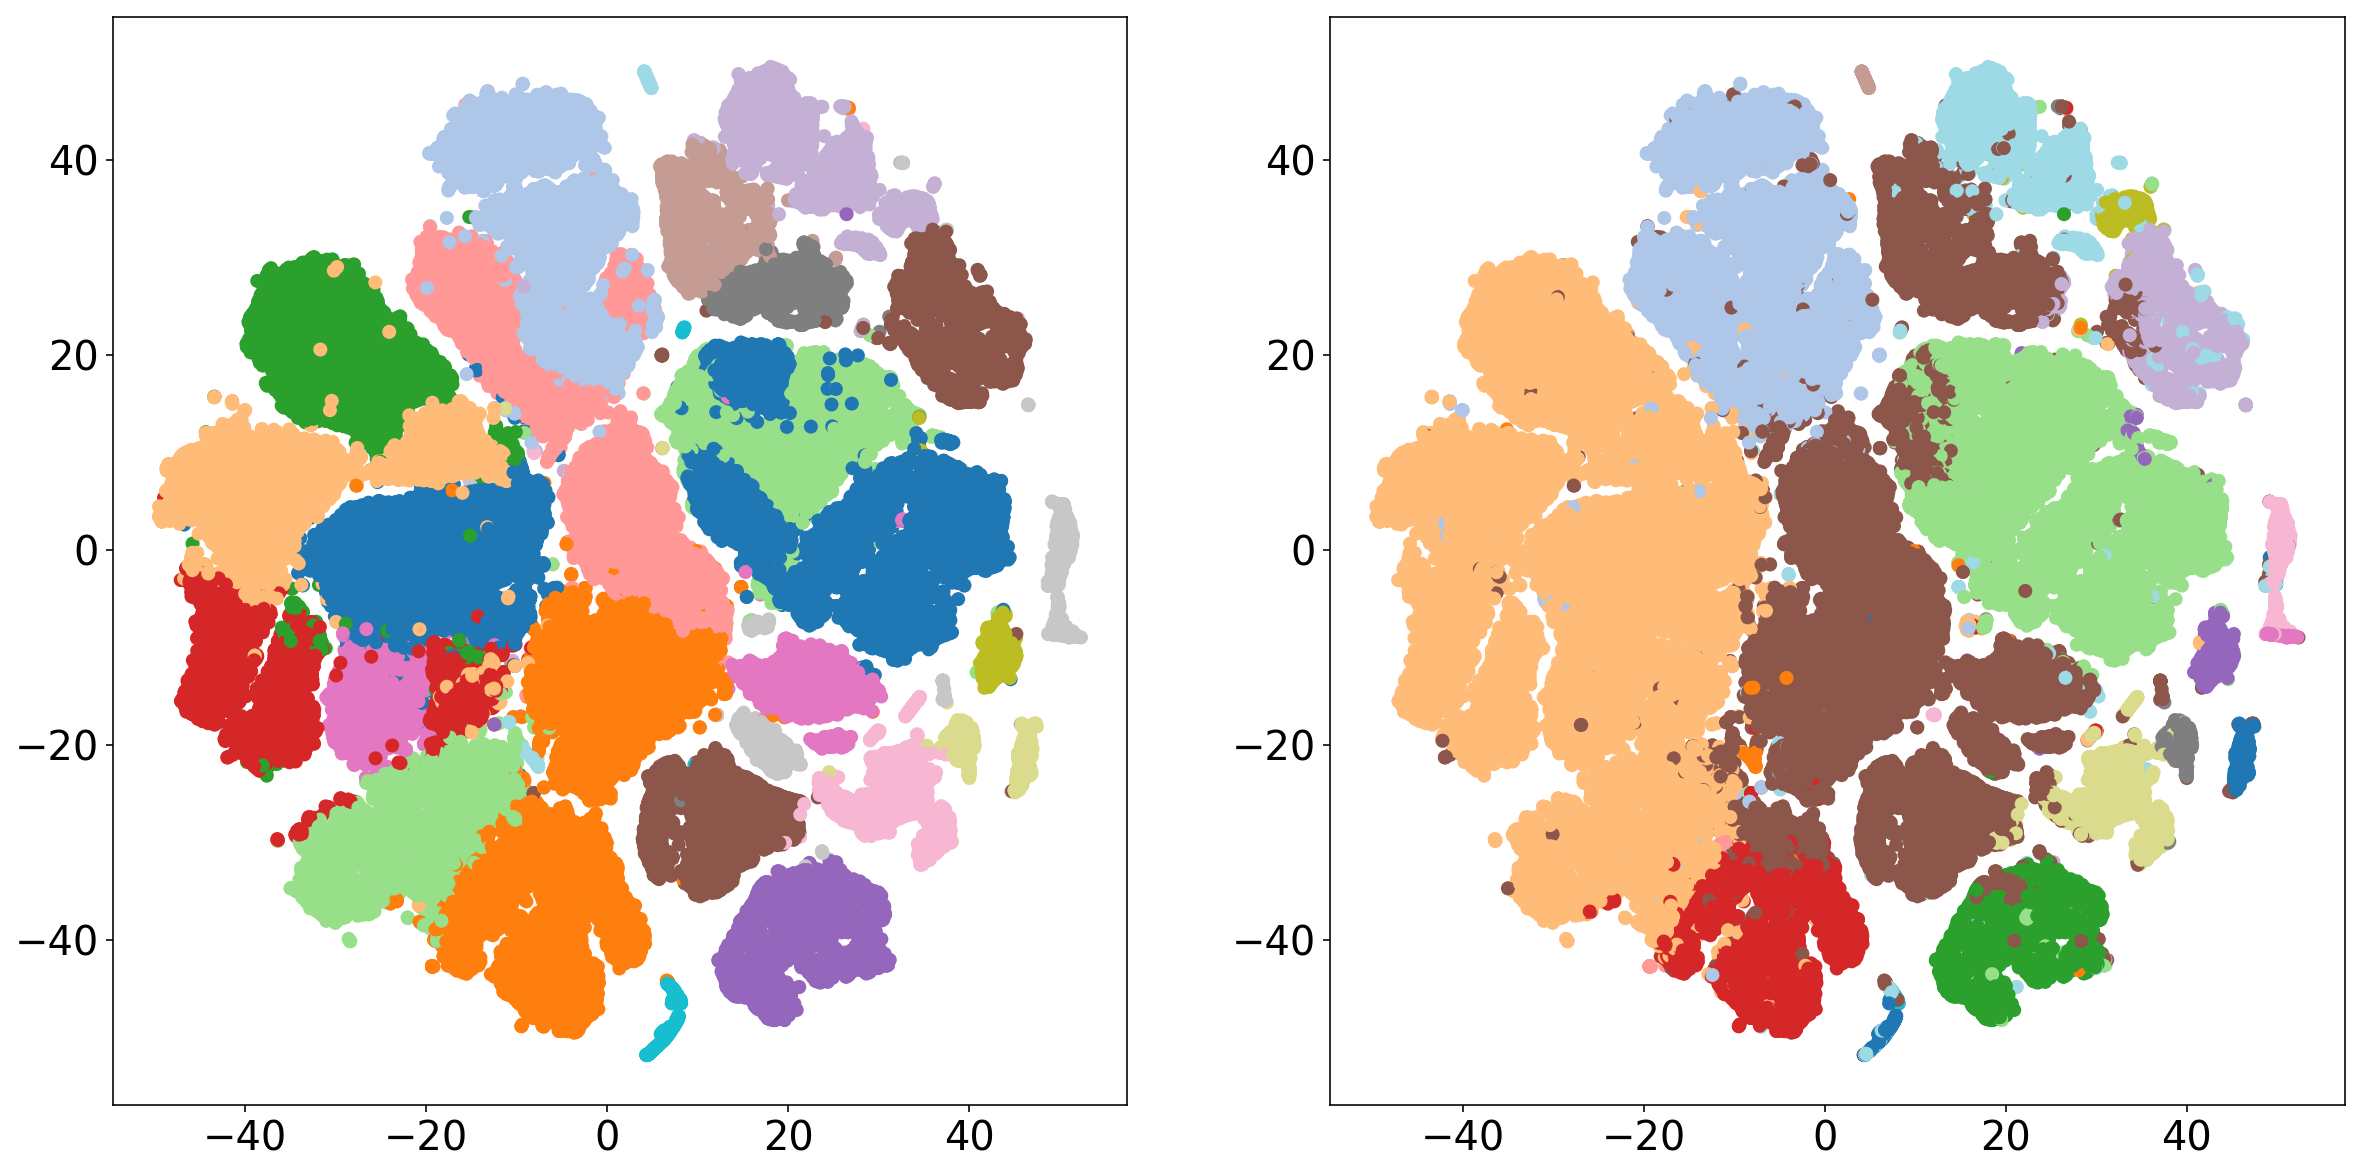

In [69]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

x = gene.obsm["X_pca_tsne"][:,0]
y = gene.obsm["X_pca_tsne"][:,1]
c = gene.obs["leiden"].astype(int)

ax[0].scatter(x, y, c = c, cmap='tab20')

x = gene.obsm["X_pca_tsne"][:,0]
y = gene.obsm["X_pca_tsne"][:,1]
c = gene.obs["subclass_id"].astype(int)

ax[1].scatter(x, y, c = c, cmap='tab20')

plt.show()

# Get the average cell for each cluster

In [3]:
tenxgene = anndata.read_h5ad("cell_ranger_annotation/10xv3.h5ad")
tenxgene.obs["cell_id"] = tenxgene.obs.index.values

In [4]:
ssgene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
print(ssgene)
print(tenxgene)

AnnData object with n_obs × n_vars = 6043 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'
AnnData object with n_obs × n_vars = 94089 × 18589 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'n_counts', 'percent_mito', 'n_genes', 'leiden', 'louvain', 'cell_id'
    var: 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_pca', 'X_pca_

In [6]:
tenxgene = tenxgene[:,~tenxgene.var["gene_name"].duplicated()]
ssgene = ssgene[:,~ssgene.var["gene_name"].duplicated()]

In [7]:
common_genes = np.intersect1d(ssgene.var.gene_name.values, tenxgene.var.gene_name.values)

In [8]:
tenx = tenxgene[:,tenxgene.var.gene_name.isin(common_genes)]
ss = ssgene[:,ssgene.var.gene_name.isin(common_genes)]

In [9]:
print(ss)
print(tenx)

View of AnnData object with n_obs × n_vars = 6043 × 16448 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'
View of AnnData object with n_obs × n_vars = 94089 × 16448 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'n_counts', 'percent_mito', 'n_genes', 'leiden', 'louvain', 'cell_id'
    var: 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 

In [10]:
def group_mtx_by_cluster(mtx, components, features, s2t, source_id="transcript_id", target_id="gene_id", by="features"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [243]:
%%time

mtx        = ss.X
components = ss.obs.cell_id.values
assignments   = ss.obs.cell_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = ss.obs

# Data for gene matrix
X1, c1, f1 = group_mtx_by_cluster(mtx, components, assignments, s2t, source_id="cell_id", target_id="subclass_label")

CPU times: user 865 ms, sys: 152 ms, total: 1.02 s
Wall time: 1.02 s


In [245]:
%%time

mtx           = tenx.X
components    = tenx.obs.cell_id.values
assignments   = tenx.obs.cell_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = tenx.obs

# Data for gene matrix
X2, c2, f2 = group_mtx_by_cluster(mtx, components, assignments, s2t, source_id="cell_id", target_id="subclass_label")

CPU times: user 33.2 s, sys: 7.95 s, total: 41.2 s
Wall time: 41.2 s


In [271]:
%%time
r2 = []
for cidx, c in enumerate(f1):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]
    r, p = stats.pearsonr(x, y)
    r2.append(r**2)

CPU times: user 381 ms, sys: 589 ms, total: 970 ms
Wall time: 23 ms


In [262]:
ss_size = ss.obs["subclass_label"].value_counts()[f1]

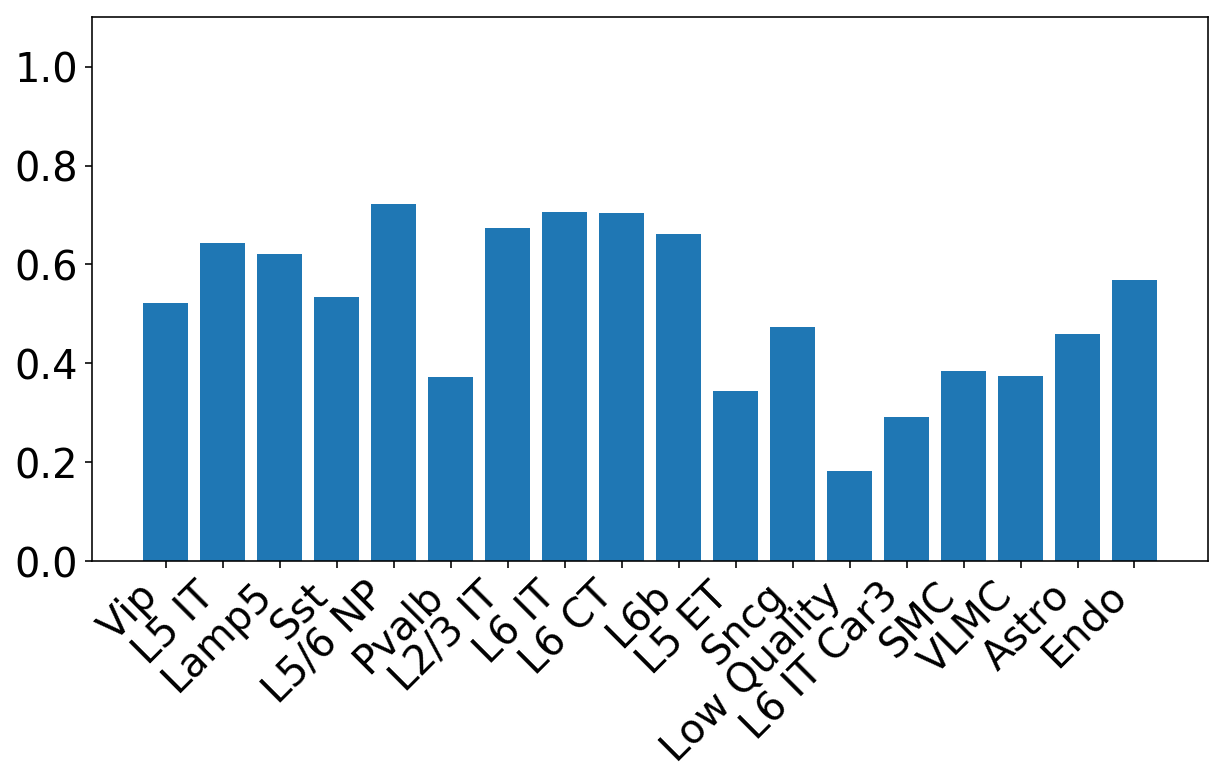

In [272]:
fig, ax = plt.subplots(figsize=(10,5))
labels = f1
lidx = np.arange(1, len(f1)+1)
x = lidx
y = r2
ax.bar(x,y)
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim((0, 1.1))
plt.show()

In [280]:
cluster_cmap = {
"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6 IT Car3" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6b" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

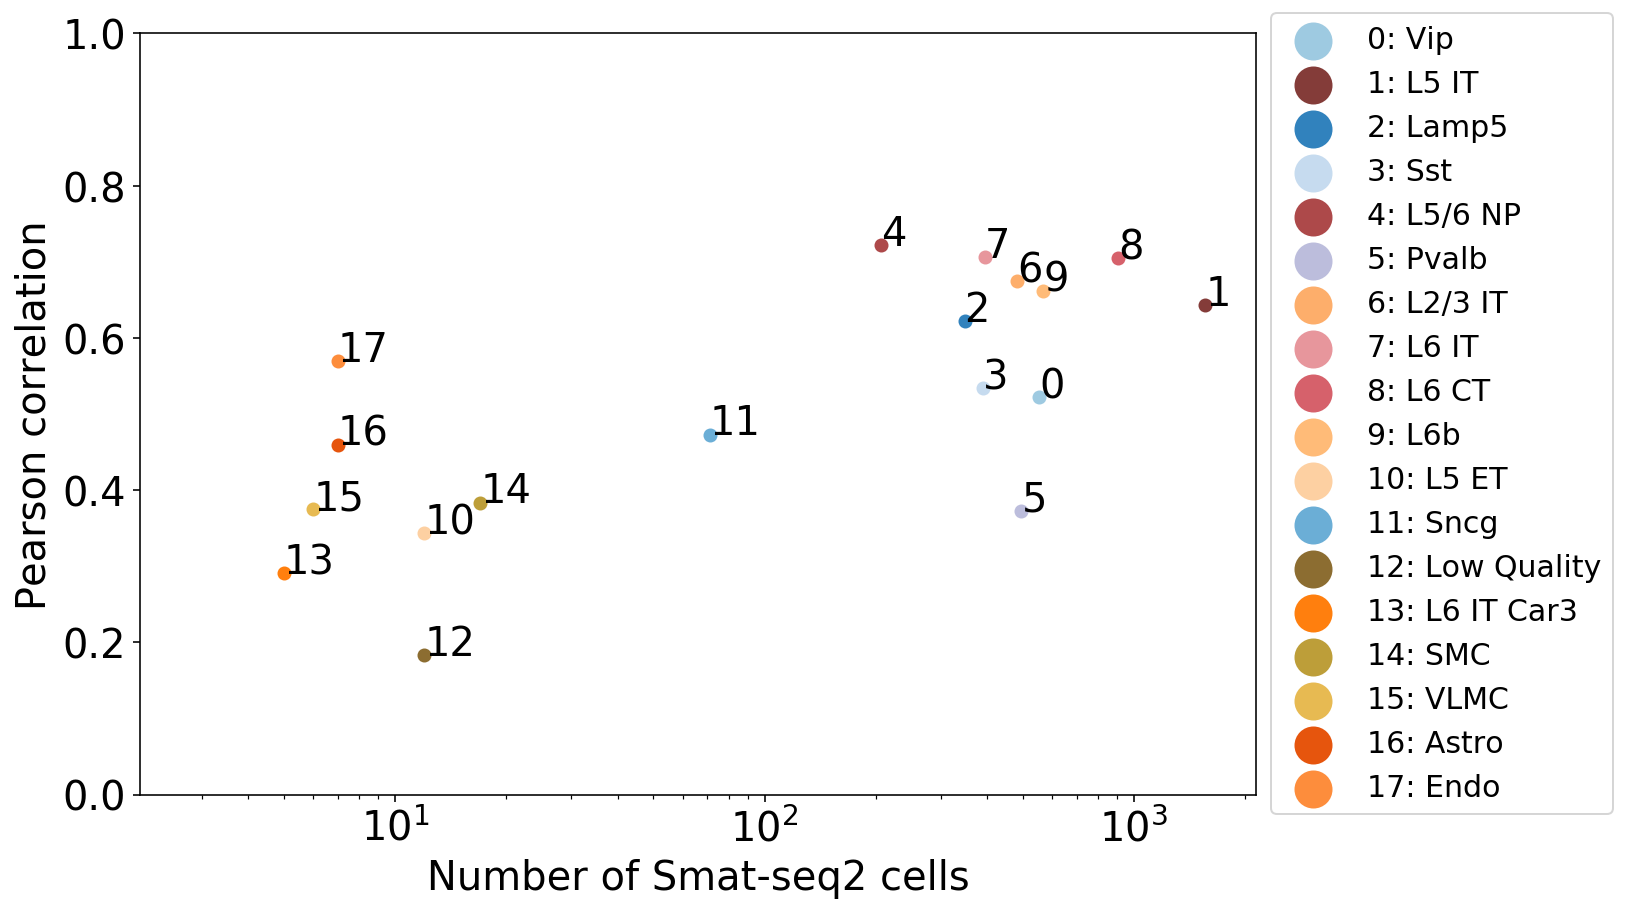

In [284]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(f1):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smat-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [285]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

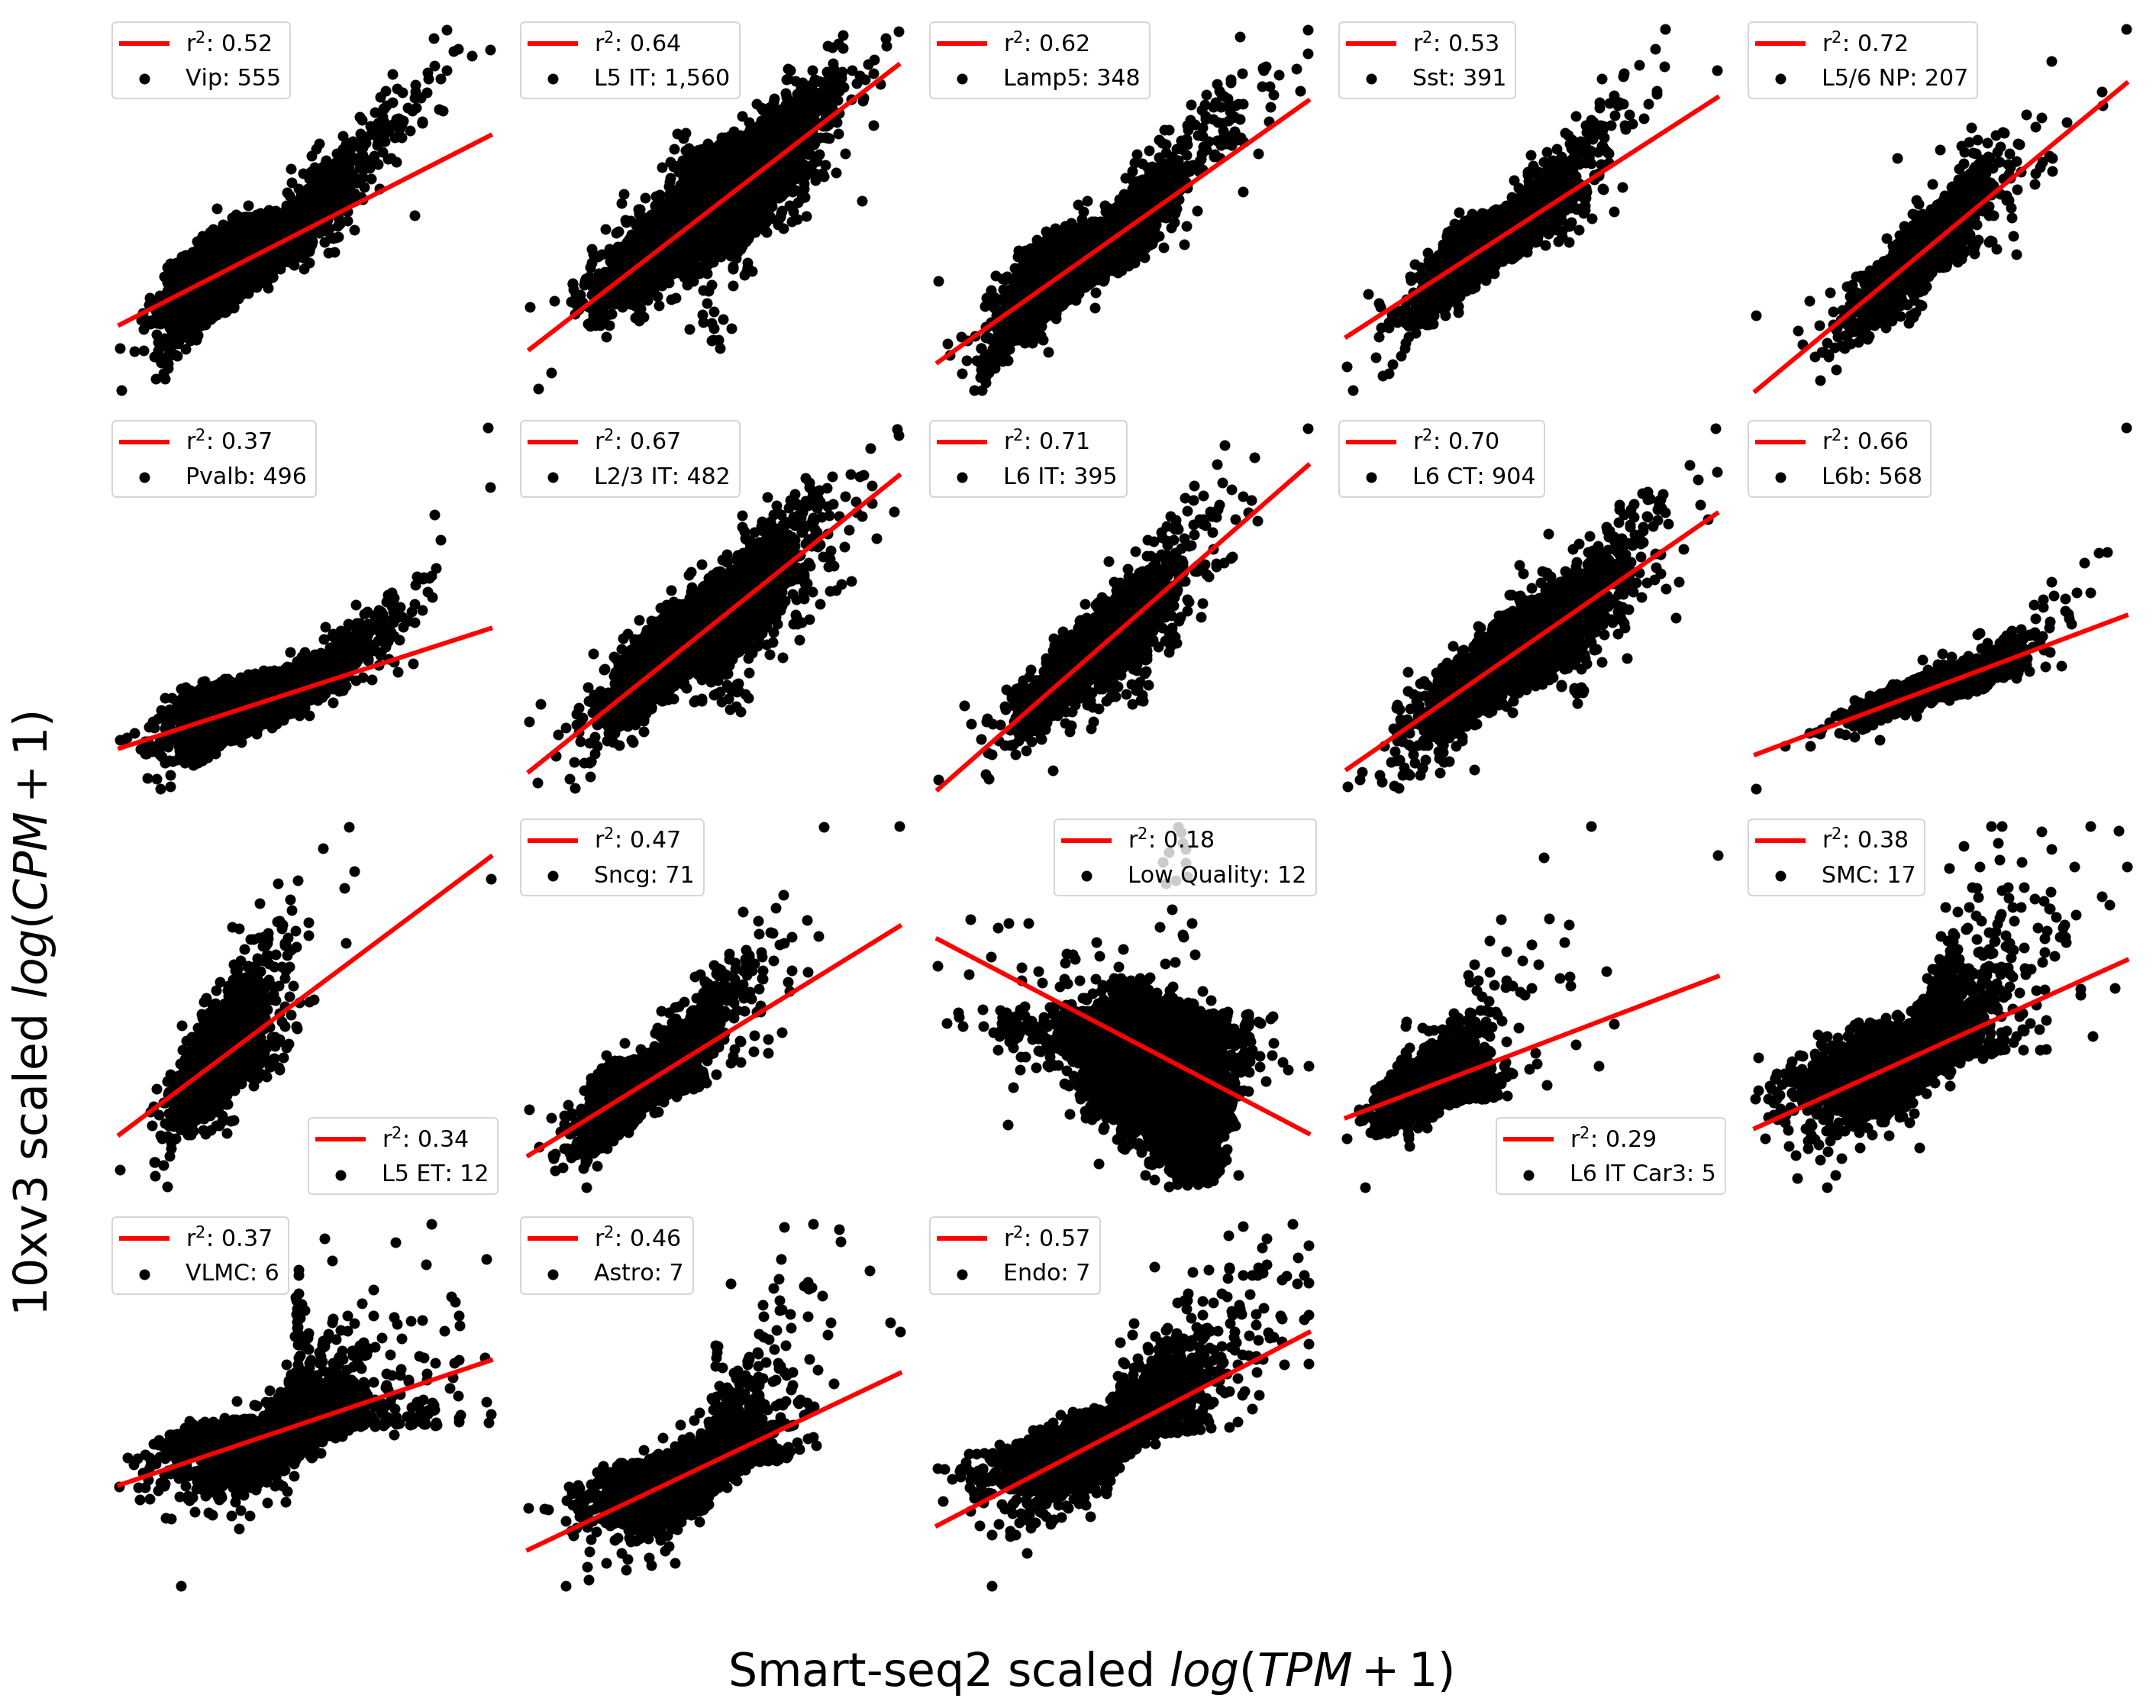

In [303]:
fig, ax = plt.subplots(figsize=(24,24), ncols=5, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(f1))

for cidx, (ax, c) in enumerate(zip(axs, f1)):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k")

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.25, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./additional_figs/10x_correlation.png", bbox_inches='tight',dpi=300)

plt.show()

In [304]:
tenx

View of AnnData object with n_obs × n_vars = 94089 × 16448 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'n_counts', 'percent_mito', 'n_genes', 'leiden', 'louvain', 'cell_id'
    var: 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

# number of cells per cluster

In [368]:
ss.obs.groupby("cluster_label").count()["cell_id"]

cluster_label
Astro Aqp4             7
Endo Slc38a5           7
L2/3 IT Cdh13 Sla    123
L2/3 IT Macc1        128
L2/3 IT S100a6       231
                    ... 
Vip Gpc3              34
Vip Htr1f             46
Vip Igfbp6            89
Vip Lmo1              24
Vip Serpinf1          45
Name: cell_id, Length: 62, dtype: int64

In [369]:
tenx.obs.groupby("cluster_label").count()["cell_id"]

cluster_label
Astro Aqp4          395
Endo Slc38a5_1      187
Endo Slc38a5_5       36
Endo_VLMC            18
Ex Endo              28
                   ... 
Vip Lypd1           228
Vip Mybpc1_1        129
Vip Mybpc1_2        103
Vip Serpinf1         44
Vip Serpinf1_low    126
Name: cell_id, Length: 147, dtype: int64

In [375]:
tenx.obs[tenx.obs["subclass_label"] == "Vip"].groupby("cluster_label")["cell_id"].sum()

cluster_label
Astro Aqp4                                                       None
Endo Slc38a5_1                                                   None
Endo Slc38a5_5                                                   None
Endo_VLMC                                                        None
Ex Endo                                                          None
                                          ...                        
Vip Lypd1           AGATCGTTCCGTAGGC-3L8TX_181211_01_A01AGTCACAGTT...
Vip Mybpc1_1        AAGTCGTCACCACTGG-3L8TX_181211_01_A01CTACTATCAC...
Vip Mybpc1_2        ACCAACAGTTGGCCGT-3L8TX_181211_01_A01CAACAGTCAG...
Vip Serpinf1        ATCGATGCAAGCAGGT-3L8TX_181211_01_A01GTAACACCAG...
Vip Serpinf1_low                                                 None
Name: cell_id, Length: 147, dtype: object

In [378]:
tenx.obs[tenx.obs["subclass_label"] == "Vip"]

,batch,cluster_id,cluster_label,subclass_label,class_label,subclass_id,class_id,n_counts,percent_mito,n_genes,leiden,louvain,cell_id
AAAGAACTCACCTTGC-3L8TX_181211_01_A01,3L8TX_181211_01_A01,124,Vip C1ql1,Vip,GABAergic,20,0,10081.0,2.856859,4170,15,13,AAAGAACTCACCTTGC-3L8TX_181211_01_A01
AAAGGTATCGGTTAGT-3L8TX_181211_01_A01,3L8TX_181211_01_A01,132,Vip Crispld2,Vip,GABAergic,20,0,7403.0,4.417128,3435,15,13,AAAGGTATCGGTTAGT-3L8TX_181211_01_A01
AAAGTGAAGTCGCGAA-3L8TX_181211_01_A01,3L8TX_181211_01_A01,134,Vip Gpc3,Vip,GABAergic,20,0,12289.0,3.474652,4932,15,13,AAAGTGAAGTCGCGAA-3L8TX_181211_01_A01
AACACACTCCGCTAGG-3L8TX_181211_01_A01,3L8TX_181211_01_A01,124,Vip C1ql1,Vip,GABAergic,20,0,18923.0,3.910585,5978,15,13,AACACACTCCGCTAGG-3L8TX_181211_01_A01
AACCAACTCACAATGC-3L8TX_181211_01_A01,3L8TX_181211_01_A01,132,Vip Crispld2,Vip,GABAergic,20,0,11499.0,2.895904,4504,15,13,AACCAACTCACAATGC-3L8TX_181211_01_A01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTAGTCAGACGCTCC-12L8TX_190430_01_G08,12L8TX_190430_01_G08,127,Vip Cbln4_2,Vip,GABAergic,20,0,14436.0,3.137988,5289,15,13,TTTAGTCAGACGCTCC-12L8TX_190430_01_G08
TTTATGCGTGTCCTAA-12L8TX_190430_01_G08,12L8TX_190430_01_G08,143,Vip Mybpc1_1,Vip,GABAergic,20,0,21506.0,2.348182,6561,15,13,TTTATGCGTGTCCTAA-12L8TX_190430_01_G08
TTTGATCAGGTACAAT-12L8TX_190430_01_G08,12L8TX_190430_01_G08,138,Vip Htr1f_2,Vip,GABAergic,20,0,26795.0,2.123531,6850,15,13,TTTGATCAGGTACAAT-12L8TX_190430_01_G08
TTTGTTGCAATGGCCC-12L8TX_190430_01_G08,12L8TX_190430_01_G08,132,Vip Crispld2,Vip,GABAergic,20,0,17228.0,1.961922,5777,15,13,TTTGTTGCAATGGCCC-12L8TX_190430_01_G08


In [383]:
tenx.obs.cluster_label.value_counts()

L5 IT Tcap_2          17334
L2/3 IT               10915
L5 IT Tcap_1           7462
L6 CT Cpa6_2           5986
L6 CT Cpa6_1           5854
                      ...  
Ex Endo                  28
L6b Kcnip1               23
Endo_VLMC                18
Oligo Opalin_neuon       16
SMC                      11
Name: cluster_label, Length: 147, dtype: int64

In [382]:
tenx.obs[tenx.obs["subclass_label"] == "Vip"].groupby("cluster_label").count()["batch"]

cluster_label
Astro Aqp4            0
Endo Slc38a5_1        0
Endo Slc38a5_5        0
Endo_VLMC             0
Ex Endo               0
                   ... 
Vip Lypd1           228
Vip Mybpc1_1        129
Vip Mybpc1_2        103
Vip Serpinf1         44
Vip Serpinf1_low      0
Name: batch, Length: 147, dtype: int64

In [395]:
ss.obs

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,cell_id,subclass_id,class_id,cell_TPM,percent_mito,n_genes,pass_count_filter,leiden,louvain
0,10,Vip Chat_1,Vip,GABAergic,#FF00FF,33,LS-15395_S47_E1-50,17,0,2.231106e+06,3.020072,8525,True,8,11
1,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S48_E1-50,4,1,2.255406e+06,2.109199,12731,True,6,8
2,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,194,LS-15395_S49_E1-50,10,0,2.166159e+06,1.651033,11062,True,14,13
3,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S50_E1-50,4,1,2.254062e+06,3.459487,13121,True,6,8
4,20,Sst Myh8_2,Sst,GABAergic,#D27A2A,55,LS-15395_S51_E1-50,15,0,2.077010e+06,1.302979,9936,True,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6573,7,Sncg,Sncg,GABAergic,#9900B3,77,SM-GE935_S378_E1-50,14,0,5.323774e+05,1.536692,8187,True,9,10
6574,18,Sst Chodl,Sst,GABAergic,#FFFF00,17,SM-GE935_S379_E1-50,15,0,5.485881e+05,2.142956,7418,True,11,6
6575,25,Pvalb Reln,Pvalb,GABAergic,#BC2D71,292,SM-GE935_S380_E1-50,12,0,5.278382e+05,2.758611,8291,True,4,4
6576,7,Sncg,Sncg,GABAergic,#9900B3,77,SM-GE935_S381_E1-50,14,0,5.714714e+05,1.891783,9502,True,9,10


In [ ]:
tmp = ss

In [402]:
ss[ss.obs["subclass_label"] == "Vip"].obs["cluster_label"].value_counts()

Vip Igfbp6      89
Vip Chat_2      84
Vip Crispld2    76
Vip Chat_3      67
Vip C1ql1       59
Vip Htr1f       46
Vip Serpinf1    45
Vip Gpc3        34
Vip Chat_1      31
Vip Lmo1        24
Name: cluster_label, dtype: int64

In [418]:
cluster_cmap["doublet"] = (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  )  # 756bb1
cluster_cmap["Macrophage"] =     (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  )  # 9e9ac8
cluster_cmap["OPC"] =     (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  )  # bcbddc
cluster_cmap["Oligo"] =     (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  )  # dadaeb

In [414]:
tenx_labels.tolist()

['Astro',
 'Endo',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'Lamp5',
 'Low Quality',
 'Macrophage',
 'OPC',
 'Oligo',
 'Pvalb',
 'SMC',
 'Sncg',
 'Sst',
 'VLMC',
 'Vip',
 'doublet']

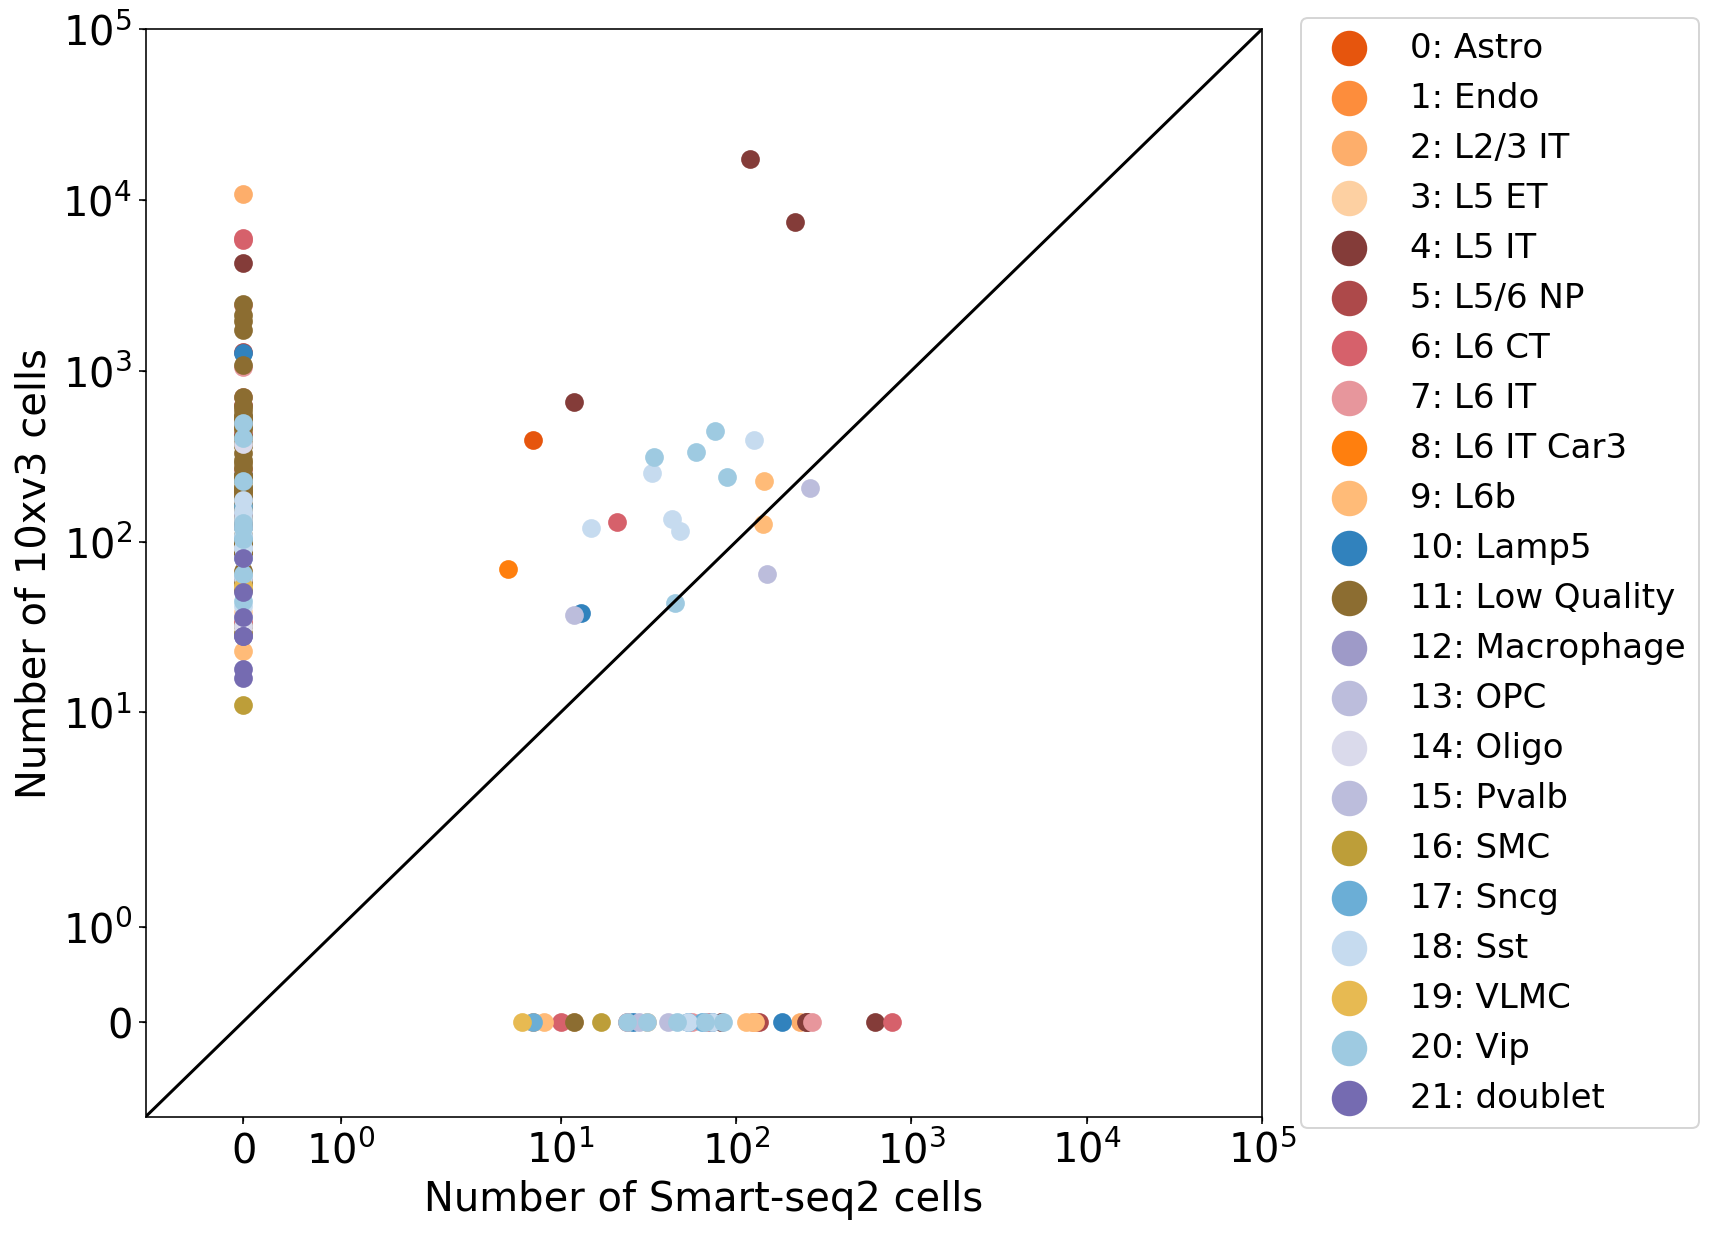

In [457]:
fig, ax = plt.subplots(figsize=(10,10))

ss_labels = ss.obs.groupby("subclass_label").count()["cell_id"].index
tenx_labels = tenx.obs.groupby("subclass_label").count()["cell_id"].index

size=70
for lidx, l in enumerate(tenx_labels):
    if l not in ss_labels:

        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        x = np.zeros_like(y)
        
        ax.scatter(x, y, color = cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
    else: 
            
        x = ss[ss.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        union = np.union1d(x.index, y.index)
        
        x_idx = [np.where(union==i)[0][0] for i in x.index]
        y_idx = [np.where(union==i)[0][0] for i in y.index]
        
        xx = np.zeros_like(union)
        xx[x_idx] = x.values
        
        yy = np.zeros_like(union)
        yy[y_idx] = y.values
        
        ax.scatter(xx, yy, color=cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
        
        
        
ax.plot([-1,10**5], [-1,10**5], color="k")
ax.set_yscale('symlog')
ax.set_xscale('symlog')


ax.set_xlim(-1, 10**5)
ax.set_ylim(-1, 10**5)


ax.legend(loc="center left", bbox_to_anchor=(1.02,0.5), markerscale=2, fontsize=17)

ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Number of 10xv3 cells")
plt.savefig("./additional_figs/10x_ss_num_cells.png", bbox_inches='tight',dpi=300)

plt.show()

# Redoing with isoform filters

In [11]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [13]:
tenx.obs["subclass_label"].value_counts()

L5 IT          29721
Low Quality    22655
L6 CT          12807
L2/3 IT        10915
L6 IT           4445
L5/6 NP         3147
Vip             2966
Lamp5           2357
Sst             1869
L6b              554
Oligo            535
Astro            395
Pvalb            368
Sncg             348
doublet          257
Endo             187
L5 ET            161
OPC              145
Macrophage       122
L6 IT Car3        69
VLMC              55
SMC               11
Name: subclass_label, dtype: int64

In [16]:
tenx = tenx[:,tenx.var.sort_values("gene_name").index]
ss = ss[:,ss.var.sort_values("gene_name").index]

In [20]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

features = tenx.var.gene_name.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [22]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [23]:
mat = tenx.layers["log1p"]

#n=500
threshold = 5
frac = 0.9

lower = 0.50
upper = 0.60

#threshold=0.9

bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print("[{} of {}] {:,}: {}".format(uidx+1, unique.shape[0],arr.sum(), u) )
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

[1 of 18] 271: Astro
[2 of 18] 361: Endo
[3 of 18] 1,072: L2/3 IT
[4 of 18] 1,273: L5 ET
[5 of 18] 1,123: L5 IT
[6 of 18] 1,077: L5/6 NP
[7 of 18] 1,092: L6 CT
[8 of 18] 1,046: L6 IT
[9 of 18] 1,094: L6 IT Car3
[10 of 18] 1,037: L6b
[11 of 18] 1,137: Lamp5
[12 of 18] 590: Low Quality
[13 of 18] 1,076: Pvalb
[14 of 18] 362: SMC
[15 of 18] 1,092: Sncg
[16 of 18] 1,121: Sst
[17 of 18] 177: VLMC
[18 of 18] 1,051: Vip


In [162]:
bool_mask.sum(axis=1)

array([ 89, 109, 775, 691, 688, 616, 724, 726, 665, 664, 671, 201, 687,
       142, 705, 697,  67, 484])

In [161]:
bool_mask.sum(axis=1)

array([ 89, 109, 775, 691, 688, 616, 724, 726, 665, 664, 671, 201, 687,
       142, 705, 697,  67, 484])

In [24]:
%%time
r2 = []
ss_x = []
tenx_x = []
for uidx, u in enumerate(unique):
    print("{} of {}: {}".format(uidx+1, unique.shape[0], u))
    tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
    ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
    
    
    t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
    ss_x.append(s)
    tenx_x.append(t)
    
    r, p = stats.pearsonr(t, s)
    r2.append(r**2)

1 of 18: Astro
2 of 18: Endo
3 of 18: L2/3 IT
4 of 18: L5 ET
5 of 18: L5 IT
6 of 18: L5/6 NP
7 of 18: L6 CT
8 of 18: L6 IT
9 of 18: L6 IT Car3
10 of 18: L6b
11 of 18: Lamp5
12 of 18: Low Quality
13 of 18: Pvalb
14 of 18: SMC
15 of 18: Sncg
16 of 18: Sst
17 of 18: VLMC
18 of 18: Vip
CPU times: user 3min 50s, sys: 1min 6s, total: 4min 56s
Wall time: 4min 56s


In [25]:
r2

[0.6105213536002706,
 0.6921643090795198,
 0.6681091704926505,
 0.44612358984796346,
 0.5666699199525652,
 0.7167923219027208,
 0.5570595150248447,
 0.7001684593570514,
 0.23700472919259355,
 0.6969083817982185,
 0.8015858030734768,
 0.3339100474264342,
 0.7200101729409722,
 0.5354227276903308,
 0.6811025614446348,
 0.7713340507283682,
 0.4272268214773479,
 0.7621656000299528]

In [26]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

In [27]:
cluster_cmap = {
"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6 IT Car3" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6b" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

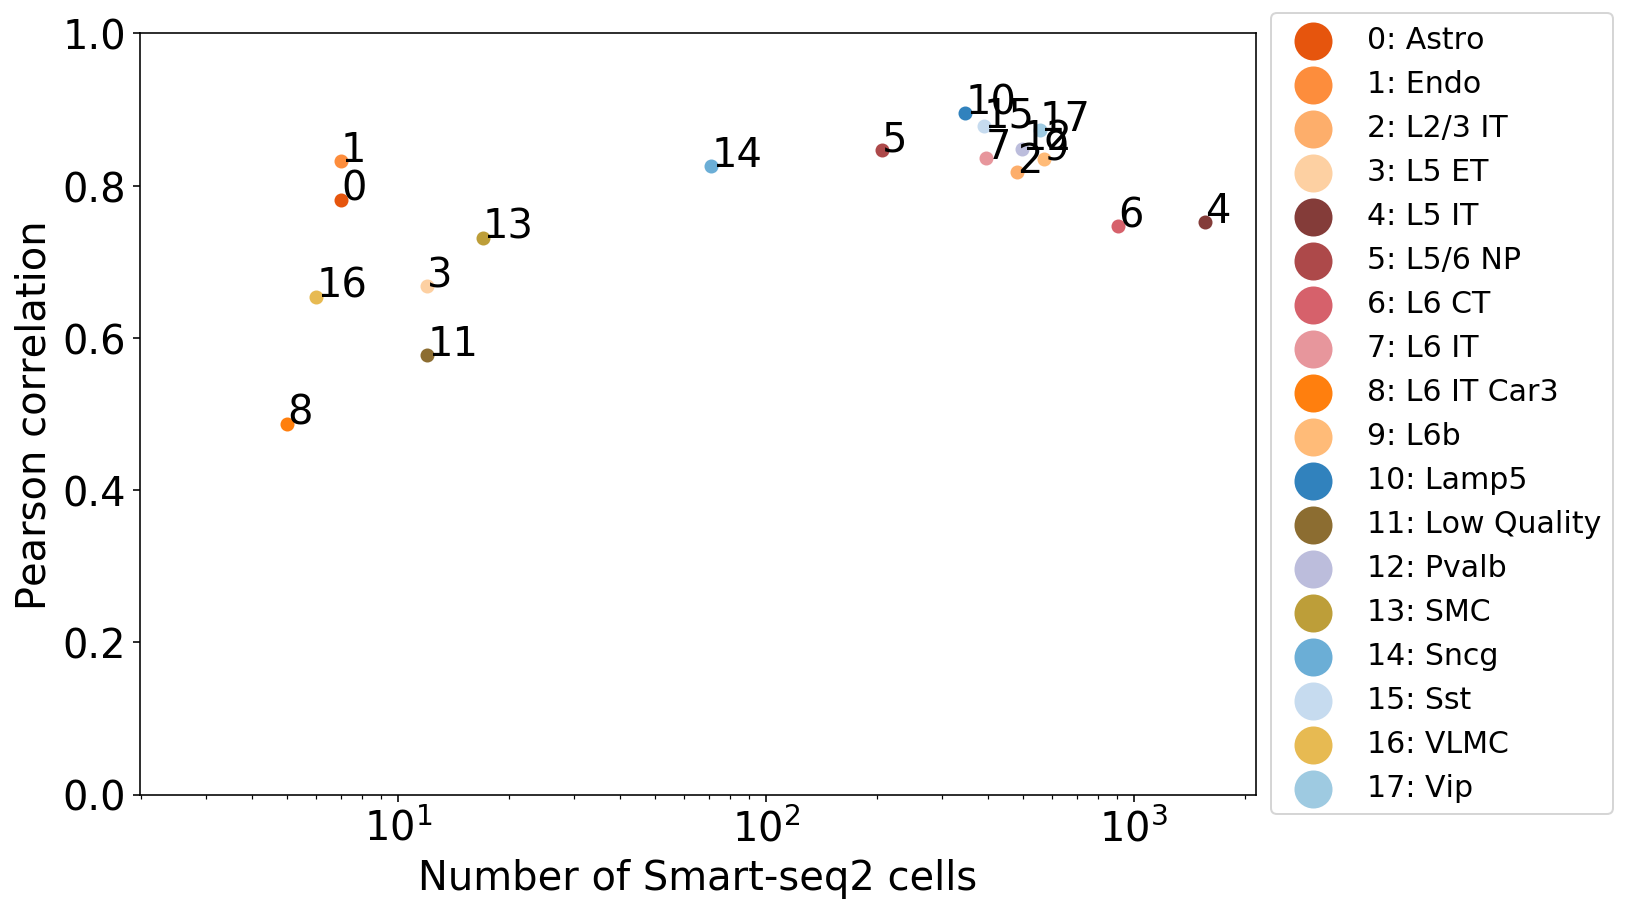

In [28]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], np.sqrt(y[i])))
    ax.scatter(x[i], np.sqrt(y[i]), label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
#plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

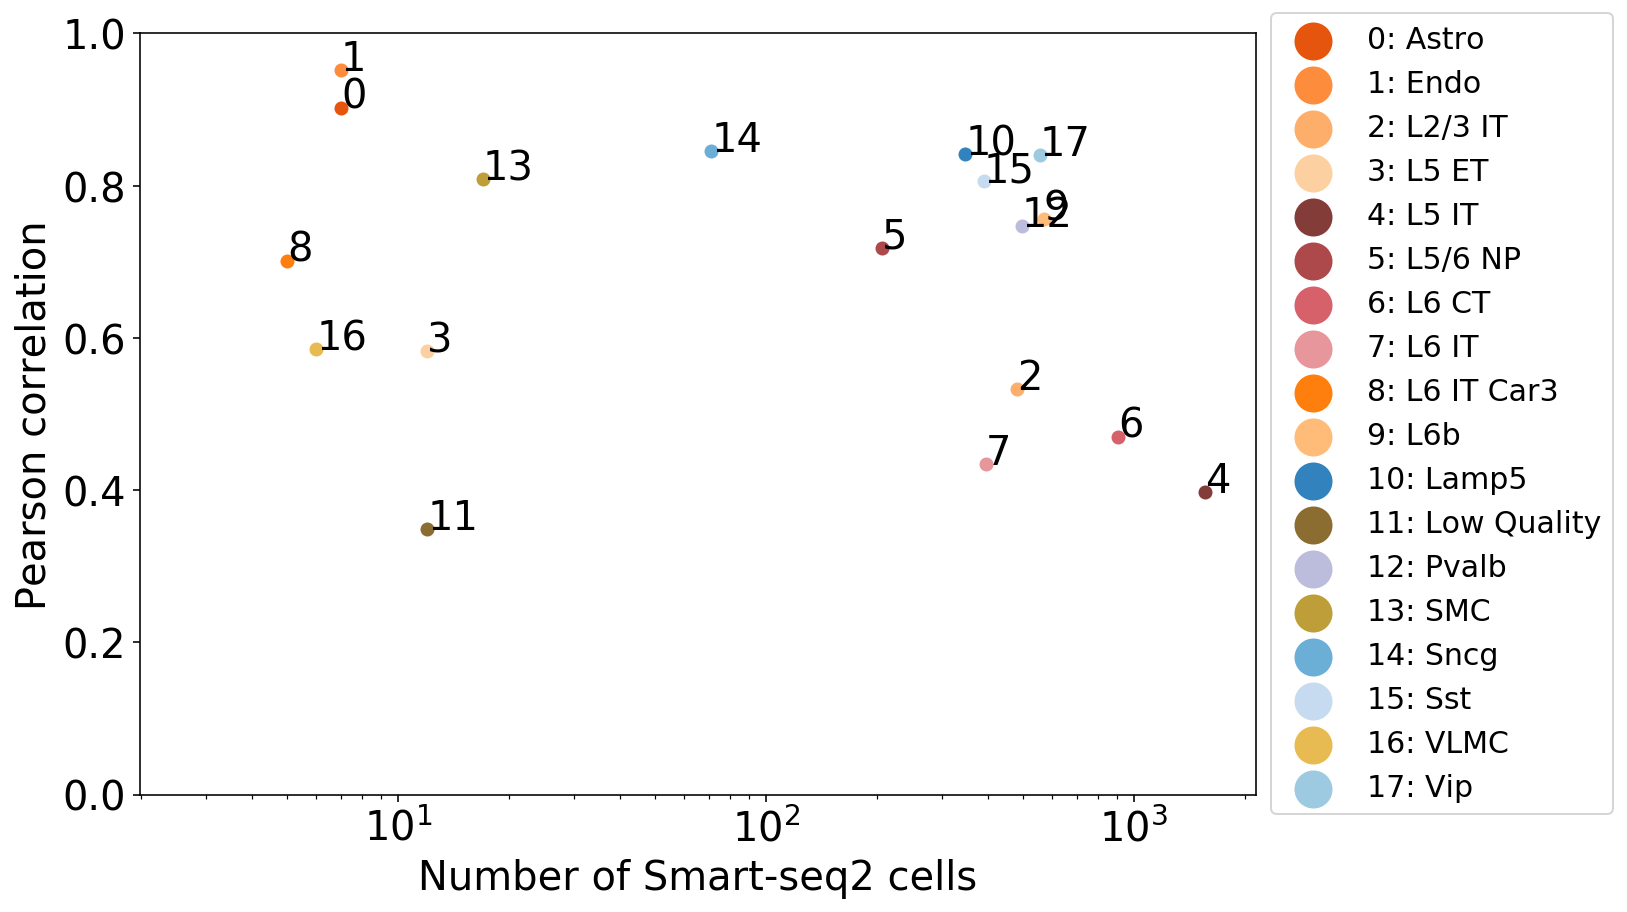

In [108]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], np.sqrt(y[i])))
    ax.scatter(x[i], np.sqrt(y[i]), label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
#plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [98]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

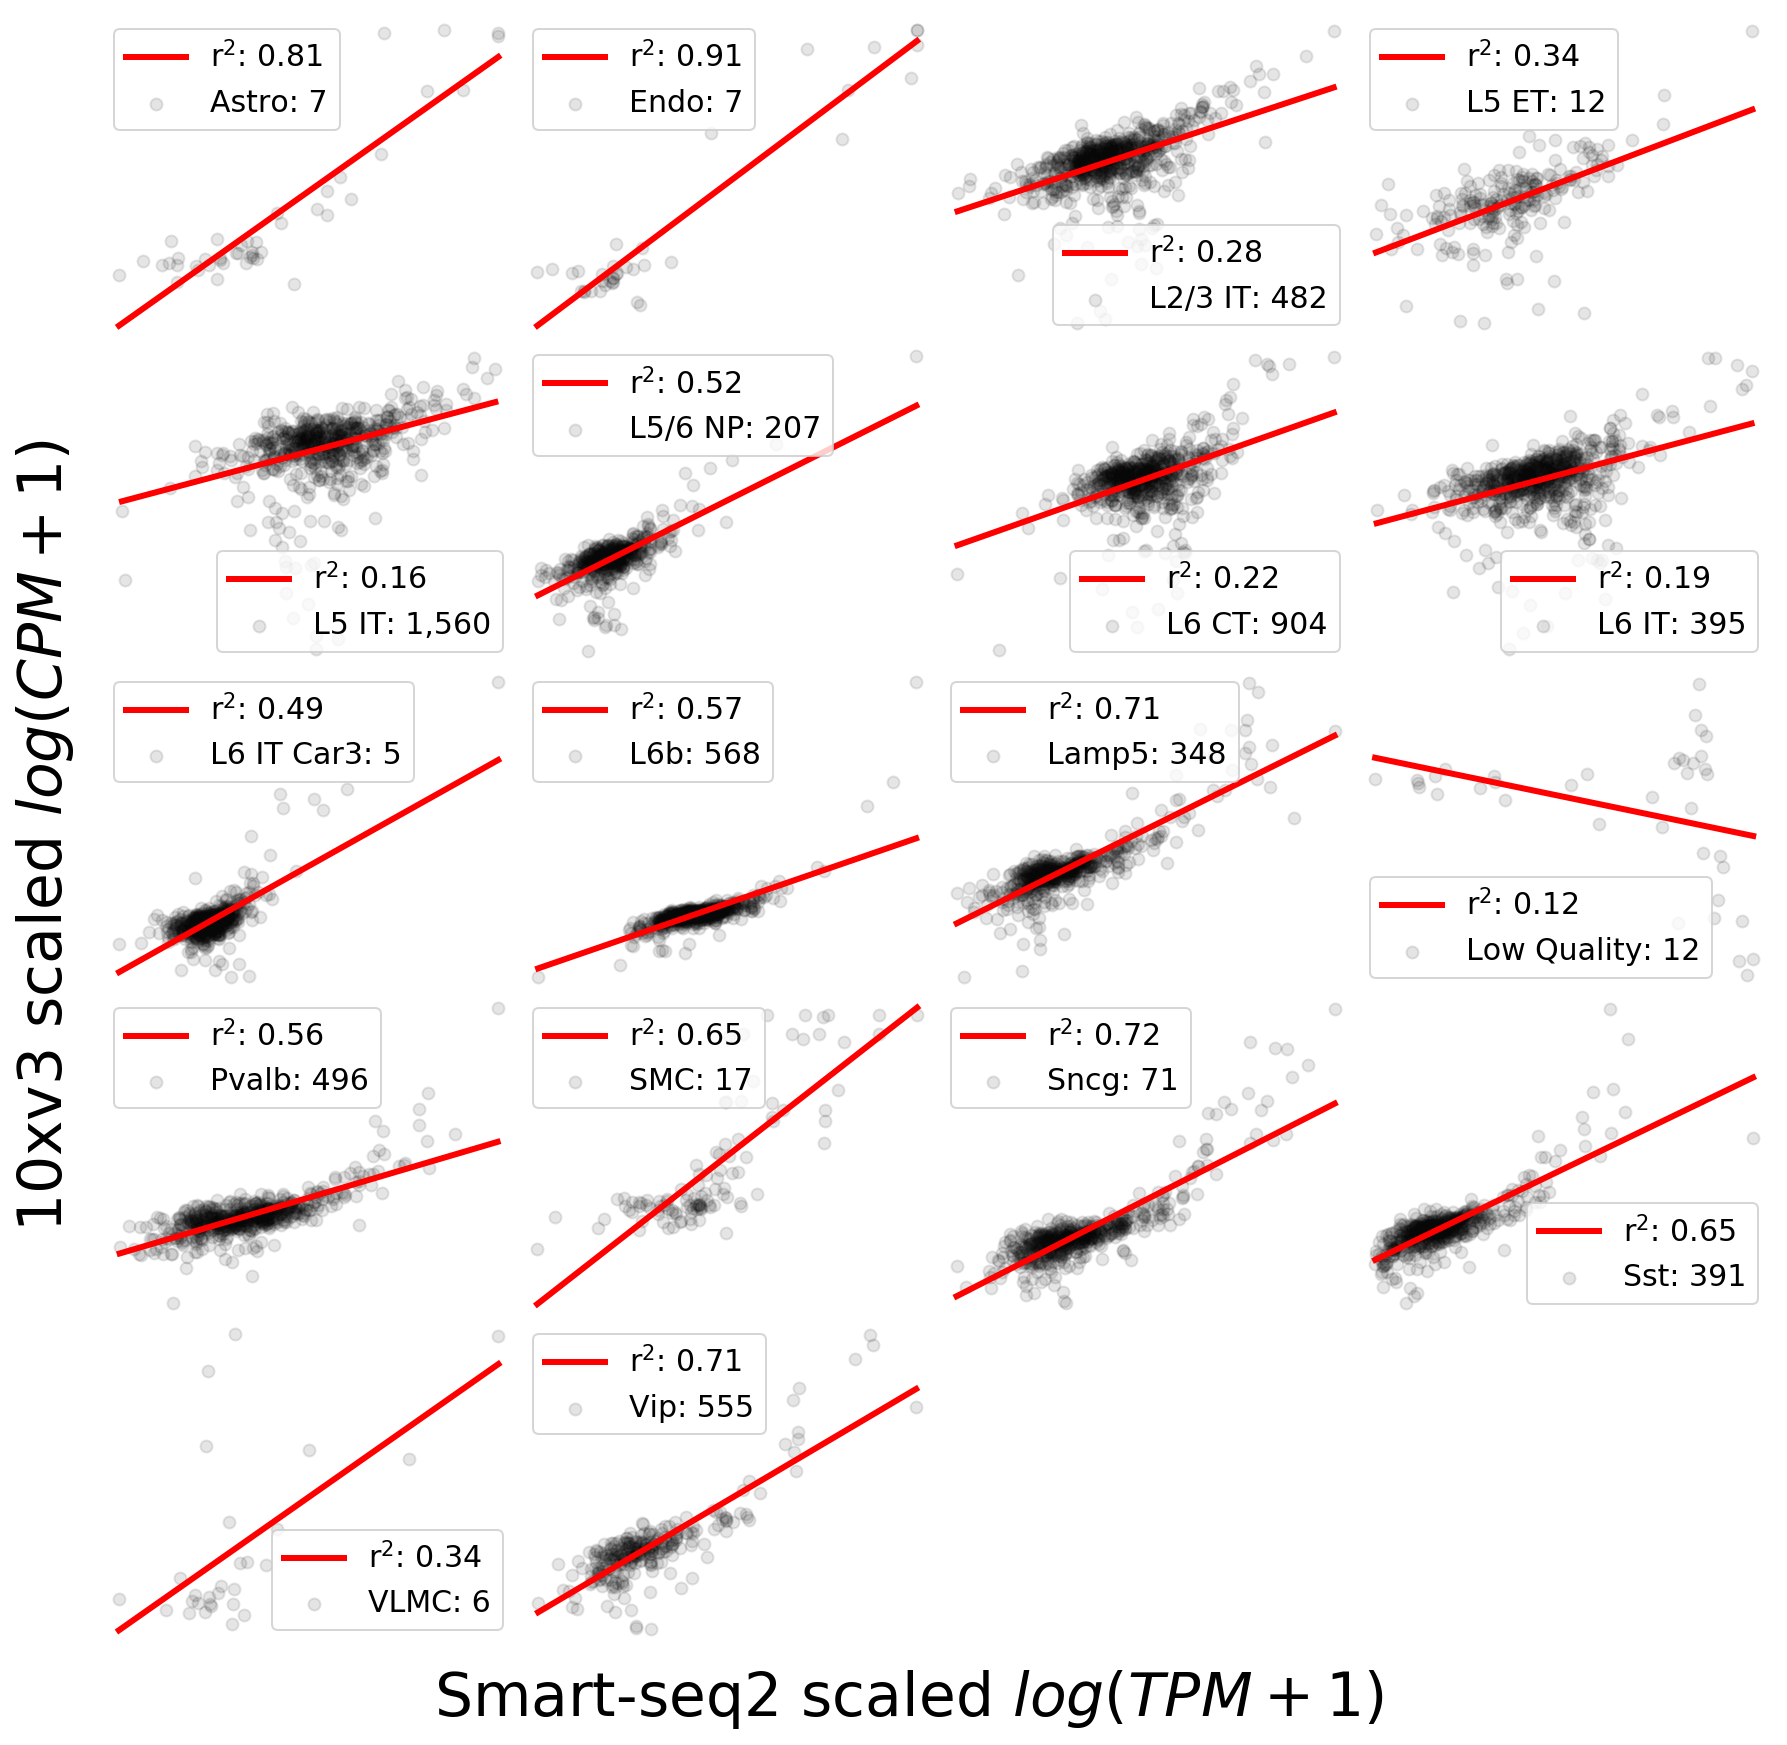

In [99]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=5)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k", alpha=0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
#plt.savefig("./additional_figs/10x_correlation.png", bbox_inches='tight',dpi=300)

plt.show()